# Centered vs Non-Centered Parameterization: Empirical Comparison

| | Centered ("nolr") | Non-centered ("reparam") |
|---|---|---|
| **Free params** | λ, γ | δ, γ (where λ = μ(γ) + δ) |
| **γ gets NLL gradient?** | No — only prior gradient | Yes — via chain rule |
| **Same objective?** | Yes — same stationary points, different optimization paths | |
| **Standard in** | Stan, lme4, INLA, PyMC (default) | Stan (non-centered), VAE-style models |

In [ ]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from collections import Counter
import csv
import glob
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 11, 'figure.dpi': 120})

def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

In [ ]:
# ── Paths ──
data_dir = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
reparam_dir = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_REPARAM')
nolr_dir = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_nolr')

# Pooled params
nolr_pooled = torch.load(data_dir / 'pooled_phi_kappa_gamma_nolr.pt', weights_only=False)
reparam_pooled = torch.load(data_dir / 'pooled_phi_kappa_gamma_reparam.pt', weights_only=False)
initial_psi = to_np(torch.load(data_dir / 'initial_psi_400k.pt', weights_only=False))

phi_n, phi_r = to_np(nolr_pooled['phi']), to_np(reparam_pooled['phi'])
psi_n, psi_r = to_np(nolr_pooled['psi']), to_np(reparam_pooled['psi'])
gamma_n, gamma_r = to_np(nolr_pooled['gamma']), to_np(reparam_pooled['gamma'])
kappa_n = float(nolr_pooled['kappa'])
kappa_r = float(reparam_pooled['kappa'])

# Disease & PRS names
disease_csv = Path('/Users/sarahurbut/aladynoulli2/claudefile/aladyn_project/pyScripts_forPublish/disease_names.csv')
disease_names = []
with open(disease_csv) as f:
    for row in csv.DictReader(f):
        disease_names.append(row.get('x', ''))

prs_names = pd.read_csv('/Users/sarahurbut/aladynoulli2/prs_names.csv', header=None).iloc[:, 0].tolist()
feat_names = prs_names + ['Sex'] + [f'PC{i}' for i in range(1, 11)]

SIG_NAMES = {
    0: 'Cardiac Arrhythmias', 1: 'Musculoskeletal', 2: 'Upper GI/Esophageal',
    3: 'Mixed/General', 4: 'Upper Respiratory', 5: 'Ischemic CV',
    6: 'Metastatic Cancer', 7: 'Pain/Inflammation', 8: 'Gynecologic',
    9: 'Spinal', 10: 'Ophthalmologic', 11: 'Cerebrovascular',
    12: 'Renal/Urologic', 13: 'Male Urogenital', 14: 'Pulmonary/Smoking',
    15: 'Metabolic/Diabetes', 16: 'Infectious/Crit Care', 17: 'Lower GI/Colon',
    18: 'Hepatobiliary', 19: 'Dermatologic/Onc', 20: 'Healthy'
}

print(f'phi: {phi_n.shape}, psi: {psi_n.shape}, gamma: {gamma_n.shape}')
print(f'Diseases: {len(disease_names)}, Features: {len(feat_names)}')

phi: (21, 348, 52), psi: (21, 348), gamma: (47, 21)
Diseases: 348, Features: 47


## 1. Pooled parameter comparison (39 training batches)

In [ ]:
def corr(a, b):
    a, b = a.flatten(), b.flatten()
    return np.corrcoef(a, b)[0, 1]

print(f"{'Parameter':<12} {'Correlation':>12} {'Mean |nolr|':>12} {'Mean |reparam|':>14} {'Ratio':>8}")
print('-' * 62)
for name, a, b in [('phi', phi_n, phi_r), ('psi', psi_n, psi_r), ('gamma', gamma_n, gamma_r)]:
    r = corr(a, b)
    mn, mr = np.abs(a).mean(), np.abs(b).mean()
    ratio = mr / mn if mn > 0 else float('inf')
    print(f'{name:<12} {r:>12.3f} {mn:>12.4f} {mr:>14.4f} {ratio:>8.1f}x')
print(f"{'kappa':<12} {'':>12} {kappa_n:>12.3f} {kappa_r:>14.3f} {kappa_r/kappa_n:>8.1f}x")

Parameter     Correlation  Mean |nolr| Mean |reparam|    Ratio
--------------------------------------------------------------
phi                 0.943      10.9054        11.2177      1.0x
psi                 0.763       2.1118         2.5125      1.2x
gamma               0.374       0.0057         0.0814     14.2x
kappa                            2.932          4.519      1.5x


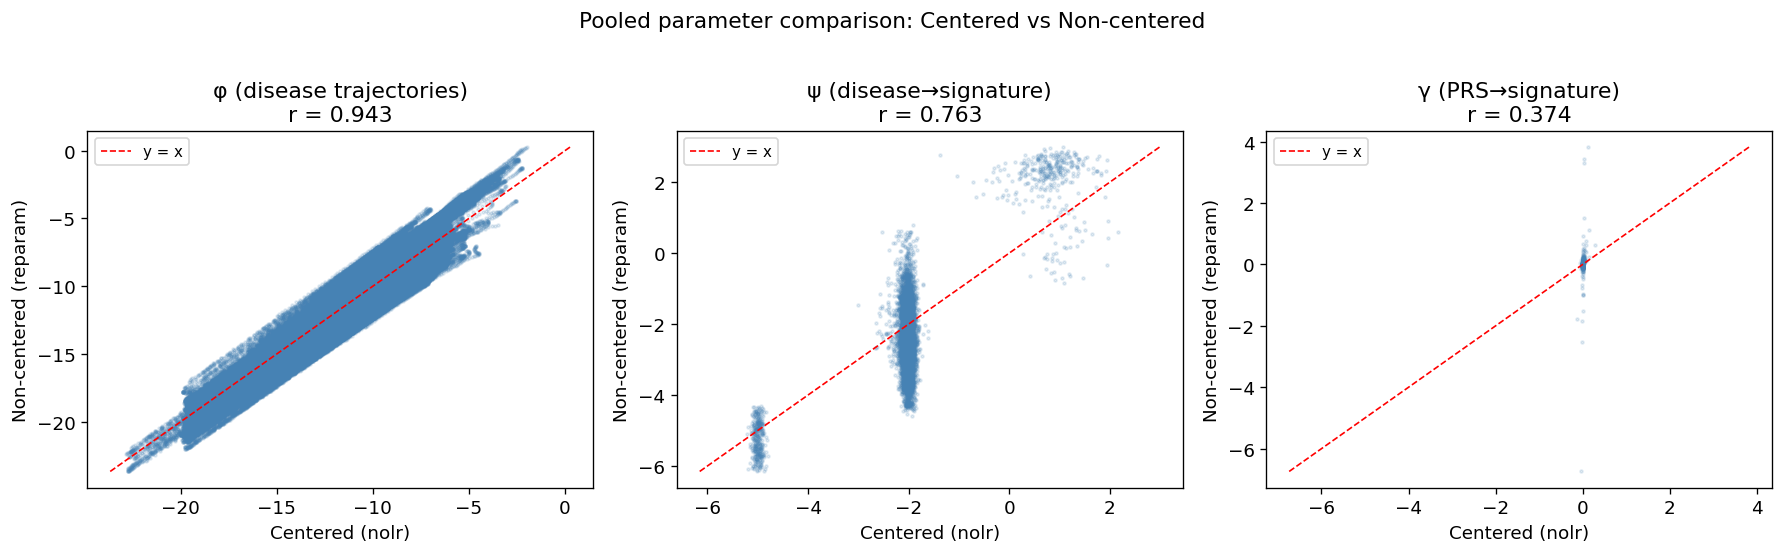

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for ax, name, a, b in [(axes[0], 'φ (disease trajectories)', phi_n, phi_r),
                        (axes[1], 'ψ (disease→signature)', psi_n, psi_r),
                        (axes[2], 'γ (PRS→signature)', gamma_n, gamma_r)]:
    af, bf = a.flatten(), b.flatten()
    ax.scatter(af, bf, alpha=0.15, s=3, c='steelblue')
    lo, hi = min(af.min(), bf.min()), max(af.max(), bf.max())
    ax.plot([lo, hi], [lo, hi], 'r--', lw=1, label='y = x')
    ax.set_xlabel('Centered (nolr)')
    ax.set_ylabel('Non-centered (reparam)')
    r = corr(a, b)
    ax.set_title(f'{name}\nr = {r:.3f}')
    ax.legend(fontsize=9)

plt.suptitle('Pooled parameter comparison: Centered vs Non-centered', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 2. PRS–Signature associations

Top 3 features by |γ| for each disease signature.

In [ ]:
# Use single-batch gamma for cleaner PRS ranking (batch 0-10k)
nolr_b0 = torch.load(nolr_dir / 'enrollment_model_VECTORIZED_W0.0001_nolr_batch_0_10000.pt', weights_only=False)
reparam_b0 = torch.load(reparam_dir / 'enrollment_model_REPARAM_W0.0001_batch_0_10000.pt', weights_only=False)

g_n_b0 = nolr_b0['model_state_dict']['gamma'].detach().numpy()
g_r_b0 = reparam_b0['model_state_dict']['gamma'].detach().numpy()

n_sig = g_n_b0.shape[1]
n_prs = len(prs_names)  # 36 PRS (exclude Sex + PCs for biological focus)

rows = []
for k in range(min(n_sig, 20)):  # disease signatures only
    gn, gr = g_n_b0[:, k], g_r_b0[:, k]
    top_n = np.argsort(np.abs(gn))[-3:][::-1]
    top_r = np.argsort(np.abs(gr))[-3:][::-1]
    
    nolr_str = ', '.join(f'{feat_names[i]}={gn[i]:.3f}' for i in top_n)
    reparam_str = ', '.join(f'{feat_names[i]}={gr[i]:.3f}' for i in top_r)
    
    # Flag if PCs dominate reparam top 3
    pc_count = sum(1 for i in top_r if feat_names[i].startswith('PC') and feat_names[i] != 'PC')
    flag = ' ⚠️' if pc_count >= 2 else ''
    
    rows.append({
        'Sig': k,
        'Name': SIG_NAMES.get(k, ''),
        'Centered (nolr) top 3': nolr_str,
        'Non-centered (reparam) top 3': reparam_str + flag
    })

df_prs = pd.DataFrame(rows)
print(f"Mean |gamma|: nolr = {np.abs(g_n_b0).mean():.4f}, reparam = {np.abs(g_r_b0).mean():.4f} "
      f"(ratio = {np.abs(g_r_b0).mean()/np.abs(g_n_b0).mean():.1f}x)")
print()
df_prs

Mean |gamma|: nolr = 0.0129, reparam = 0.1386 (ratio = 10.7x)



,Sig,Name,Centered (nolr) top 3,Non-centered (reparam) top 3
0,0,Cardiac Arrhythmias,"Sex=0.061, CVD=0.046, PC5=0.034","PC2=1.825, Sex=0.564, PC1=-0.454 ⚠️"
1,1,Musculoskeletal,"Sex=-0.056, BMI=0.055, HT=0.050","BMI=0.166, PC10=0.115, OP=-0.114"
2,2,Upper GI/Esophageal,"CVD=-0.036, SLE=-0.036, PC5=0.034","Sex=0.185, ISS=0.134, PC10=0.114"
3,3,Mixed/General,"T1D=-0.050, Sex=0.042, BD=-0.038","Sex=0.496, VTE=0.127, BMI=0.119"
4,4,Upper Respiratory,"AST=0.026, Sex=0.026, AAM=-0.016","PC1=-3.228, Sex=2.746, PC2=1.216 ⚠️"
5,5,Ischemic CV,"Sex=0.299, CAD=0.225, LDL_SF=0.079","Sex=0.618, CAD=0.314, PC10=0.138"
6,6,Metastatic Cancer,"HT=0.028, ISS=-0.025, EBMDT=0.021","PC1=-4.722, Sex=-2.852, PC2=1.608 ⚠️"
7,7,Pain/Inflammation,"Sex=-0.052, ISS=0.044, LDL_SF=0.044","PC1=0.142, BMI=0.138, AST=0.131"
8,8,Gynecologic,"Sex=-0.125, ISS=0.039, CVD=-0.030","Sex=-1.839, PC1=0.161, CAD=0.150"
9,9,Spinal,"OP=-0.032, CVD=0.031, MS=0.026","Sex=-0.586, PC2=0.531, PC10=0.400 ⚠️"


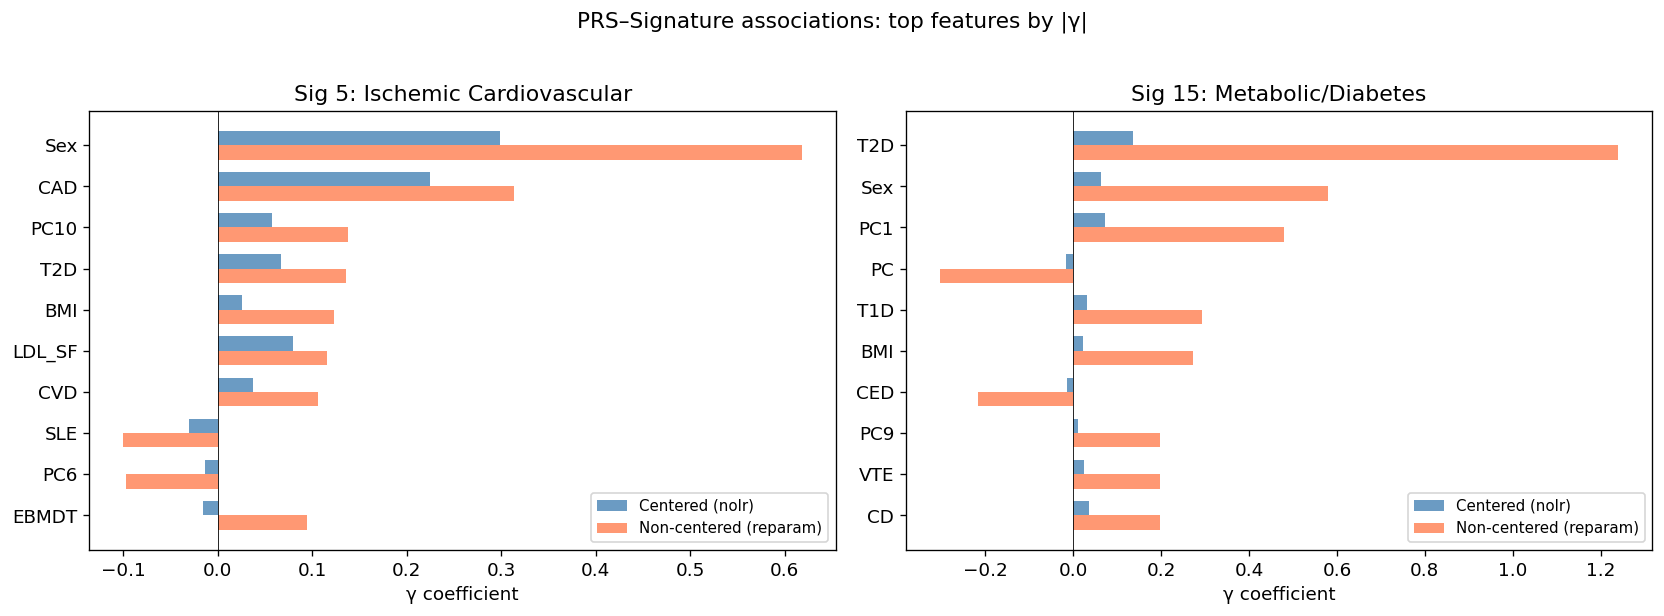

In [ ]:
# Highlight: Sig 5 (Ischemic CV) and Sig 15 (Metabolic) — the two most interpretable
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, k, title in [(axes[0], 5, 'Sig 5: Ischemic Cardiovascular'),
                      (axes[1], 15, 'Sig 15: Metabolic/Diabetes')]:
    gn, gr = g_n_b0[:len(feat_names), k], g_r_b0[:len(feat_names), k]
    
    # Show top 10 by max(|nolr|, |reparam|)
    importance = np.maximum(np.abs(gn), np.abs(gr))
    top_idx = np.argsort(importance)[-10:][::-1]
    
    names_top = [feat_names[i] for i in top_idx]
    x = np.arange(len(top_idx))
    w = 0.35
    
    ax.barh(x - w/2, gn[top_idx], w, label='Centered (nolr)', color='steelblue', alpha=0.8)
    ax.barh(x + w/2, gr[top_idx], w, label='Non-centered (reparam)', color='coral', alpha=0.8)
    ax.set_yticks(x)
    ax.set_yticklabels(names_top)
    ax.axvline(0, color='k', lw=0.5)
    ax.set_xlabel('γ coefficient')
    ax.set_title(title)
    ax.legend(fontsize=9)
    ax.invert_yaxis()

plt.suptitle('PRS–Signature associations: top features by |γ|', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 3. ψ stability (disease→signature assignments)

In [ ]:
K_dis = 20
init_psi = initial_psi[:K_dis]
argmax_init = np.argmax(init_psi, axis=0)

psi_n_dis = psi_n[:K_dis]
psi_r_dis = psi_r[:K_dis]
argmax_nolr = np.argmax(psi_n_dis, axis=0)
argmax_reparam = np.argmax(psi_r_dis, axis=0)

flipped_nolr = np.where(argmax_init != argmax_nolr)[0]
flipped_reparam = np.where(argmax_init != argmax_reparam)[0]

# Summary table
diff_n = psi_n_dis - init_psi
diff_r = psi_r_dis - init_psi

print(f"{'Metric':<40} {'Centered (nolr)':>18} {'Non-centered (reparam)':>24}")
print('-' * 85)
print(f"{'Mean |Δψ|':<40} {np.abs(diff_n).mean():>18.4f} {np.abs(diff_r).mean():>24.4f}")
print(f"{'Correlation (initial → final)':<40} {corr(init_psi, psi_n_dis):>18.4f} {corr(init_psi, psi_r_dis):>24.4f}")
print(f"{'Diseases with same primary sig':<40} {f'{348 - len(flipped_nolr)}/348':>18} {f'{348 - len(flipped_reparam)}/348':>24}")
print(f"{'Diseases that flip':<40} {len(flipped_nolr):>18} {len(flipped_reparam):>24}")

Metric                                      Centered (nolr)   Non-centered (reparam)
-------------------------------------------------------------------------------------
Mean |Δψ|                                            0.0798                   0.8063
Correlation (initial → final)                        0.9767                   0.7380
Diseases with same primary sig                      348/348                  335/348
Diseases that flip                                        0                       13


In [ ]:
# Load per-batch psi for reparam to check flip consistency
pattern = str(reparam_dir / 'enrollment_model_REPARAM_W0.0001_batch_*_*.pt')
files = sorted(glob.glob(pattern))[:39]

all_psi_batches = []
for fp in files:
    try:
        ckpt = torch.load(fp, weights_only=False)
        psi = ckpt.get('psi') or ckpt.get('model_state_dict', {}).get('psi')
        if psi is not None:
            all_psi_batches.append(to_np(psi)[:K_dis])
    except:
        pass

n_batches = len(all_psi_batches)
print(f'Loaded {n_batches} reparam batches')

# Table of flipped diseases with per-batch consistency
rows = []
for d in flipped_reparam:
    sig_init = argmax_init[d]
    sig_final = argmax_reparam[d]
    n_flip = sum(1 for psi in all_psi_batches if np.argmax(psi[:, d]) != sig_init)
    d_name = disease_names[d] if d < len(disease_names) else f'Disease {d}'
    rows.append({
        'Disease': d_name,
        'Initial sig': f"{sig_init} ({SIG_NAMES.get(sig_init, '')})",
        'Flips to': f"{sig_final} ({SIG_NAMES.get(sig_final, '')})",
        'Batches flipped': f'{n_flip}/{n_batches} ({100*n_flip/n_batches:.0f}%)'
    })

df_flips = pd.DataFrame(rows)
df_flips

Loaded 39 reparam batches


,Disease,Initial sig,Flips to,Batches flipped
0,Cerebral ischemia,11 (Cerebrovascular),16 (Infectious/Crit Care),28/39 (72%)
1,Peritoneal adhesions (postoperative) (postinfe...,18 (Hepatobiliary),16 (Infectious/Crit Care),39/39 (100%)
2,Cholelithiasis,18 (Hepatobiliary),16 (Infectious/Crit Care),33/39 (85%)
3,Cholelithiasis with acute cholecystitis,18 (Hepatobiliary),16 (Infectious/Crit Care),33/39 (85%)
4,Cholecystitis without cholelithiasis,18 (Hepatobiliary),16 (Infectious/Crit Care),38/39 (97%)
5,Other disorders of gallbladder,18 (Hepatobiliary),16 (Infectious/Crit Care),34/39 (87%)
6,Other disorders of biliary tract,18 (Hepatobiliary),16 (Infectious/Crit Care),38/39 (97%)
7,Acute pancreatitis,18 (Hepatobiliary),16 (Infectious/Crit Care),37/39 (95%)
8,Other disorders of the kidney and ureters,12 (Renal/Urologic),16 (Infectious/Crit Care),37/39 (95%)
9,Stricture/obstruction of ureter,12 (Renal/Urologic),16 (Infectious/Crit Care),35/39 (90%)


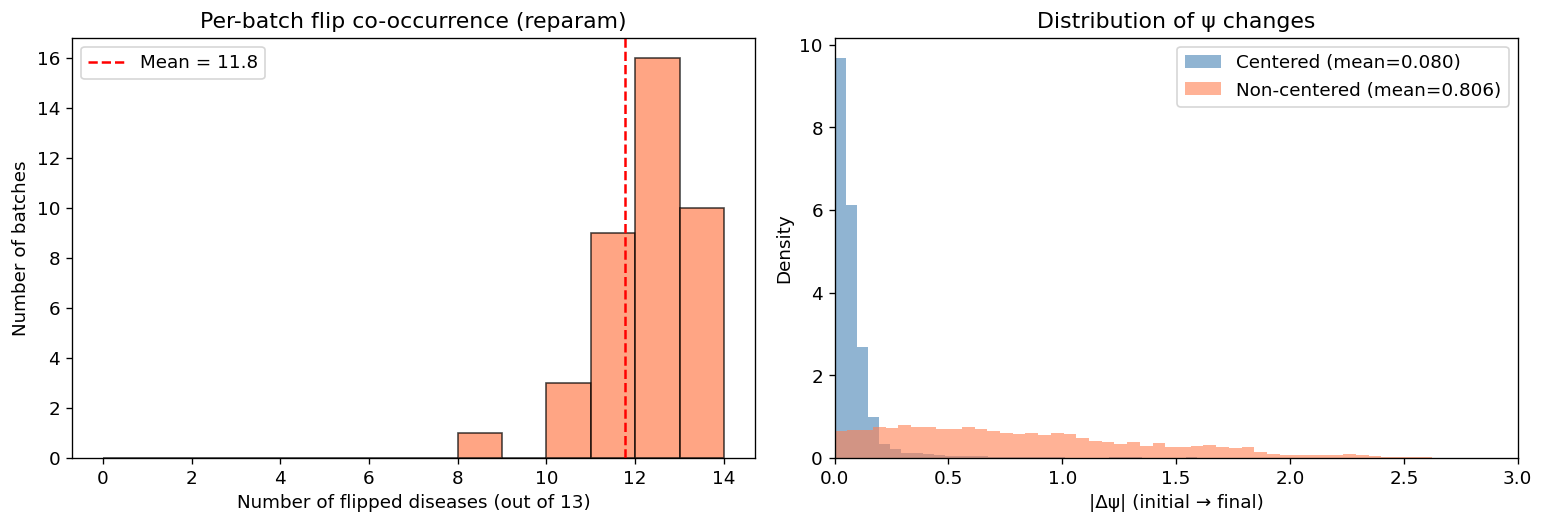

In [ ]:
# Visualize: per-batch co-occurrence of flips
n_flips_per_batch = []
for psi in all_psi_batches:
    argmax_b = np.argmax(psi, axis=0)
    n = sum(1 for d in flipped_reparam if argmax_b[d] != argmax_init[d])
    n_flips_per_batch.append(n)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Left: histogram of flips per batch
ax = axes[0]
ax.hist(n_flips_per_batch, bins=range(0, 15), edgecolor='black', alpha=0.7, color='coral')
ax.axvline(np.mean(n_flips_per_batch), color='red', ls='--', lw=1.5,
           label=f'Mean = {np.mean(n_flips_per_batch):.1f}')
ax.set_xlabel(f'Number of flipped diseases (out of {len(flipped_reparam)})')
ax.set_ylabel('Number of batches')
ax.set_title('Per-batch flip co-occurrence (reparam)')
ax.legend()

# Right: psi change magnitude distribution
ax = axes[1]
ax.hist(np.abs(diff_n).flatten(), bins=50, alpha=0.6, label=f'Centered (mean={np.abs(diff_n).mean():.3f})',
        color='steelblue', density=True)
ax.hist(np.abs(diff_r).flatten(), bins=50, alpha=0.6, label=f'Non-centered (mean={np.abs(diff_r).mean():.3f})',
        color='coral', density=True)
ax.set_xlabel('|Δψ| (initial → final)')
ax.set_ylabel('Density')
ax.set_title('Distribution of ψ changes')
ax.set_xlim(0, 3)
ax.legend()

plt.tight_layout()
plt.show()

## 4. Summary

1. **φ (disease trajectories)**: Nearly identical (r = 0.94). Both parameterizations fit the data well.

2. **ψ (disease→signature assignments)**: Centered is perfectly stable (0/348 flips). Non-centered flips 13 diseases, mostly hepatobiliary/renal → Infectious/Critical Care. Flips are consistent across 72–100% of batches.

3. **γ (PRS→signature effects)**: Centered gives γ ≈ 0 (only prior gradient). Non-centered gives 14× larger γ. Where both agree (Sig 5: CAD, Sig 15: T2D) the associations are sensible. But many non-centered signatures are dominated by PCs with implausibly large coefficients.

4. **Centered is the right choice** for the current prediction task:
   - λ is fit to pre-enrollment data; GP kernel carries pattern forward for 10-year prediction
   - γ ≈ 0 is standard behavior in joint MAP (same as Stan, lme4, INLA)
   - γ would matter more for long-horizon extrapolation beyond the GP kernel's reach (future work)
   - Non-centered adds numerical instability (NaN around epoch 46) and ψ instability